In [1]:
!pip install --upgrade scikit-learn==0.21.2
!pip install --upgrade scikit-optimize==0.7.4


     |████████████████████████████████| 6.7 MB 3.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.2 which is incompatible.
     |████████████████████████████████| 80 kB 2.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import SMOTE
from collections import Counter
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

seed = 7
np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/Major Project/New/mangalath-failure modes/Shear-Wall-Failure-Mode-master/Shear_Wall_Database.xlsx'
def dataprocessor(path):
  data1=pd.read_excel(path,sheet_name='Database')
  data=data1.loc[:, 'FailureMode':'Ab/Ag']
  data_mod_lc = data.copy()
  data_mod_lc['Section'] = data_mod_lc['Section'].astype('category')
  #print(cat_bird_lc.dtypes)
  data_mod_lc['Section'] = data_mod_lc['Section'].cat.codes
  data['Section'] = data_mod_lc['Section']
  data = pd.get_dummies(data = data , columns=['Section'] )
  X = data.loc[:, data.columns != 'FailureMode']
  y=data['FailureMode']-1
  return X,y
X,y=dataprocessor(path)
print(X.shape,y.shape)

(393, 11) (393,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape,X_test.shape)

(275, 11) (118, 11)


In [5]:
print("Train \n",Counter(y_train))
print("Test \n",Counter(y_test))

Train 
 Counter({0.0: 106, 2.0: 84, 1.0: 66, 3.0: 19})
Test 
 Counter({0.0: 46, 2.0: 38, 1.0: 30, 3.0: 4})


In [6]:
def balance(X_train,y_train):
  print("Before: ",Counter(y_train))
  smote=SMOTE()
  X_train_smote,y_train_smote=smote.fit_resample(X_train.astype('float'),y_train)
  print("After: ",Counter(y_train_smote))
  
  return X_train_smote,y_train_smote

In [7]:
# x_new,y_new=balance(X_train,y_train)

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input,Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import randint as sp_randint

In [9]:
def plot_metrics(history):
    print(history.history.keys())
    plt.figure()
    plt.title('model accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return

In [10]:
def evaluate_model(model,ytrue,ypred):
  cf_matrix=confusion_matrix(ytrue, ypred)
  plt.figure()
  sns.heatmap(cf_matrix, annot=True, 
             cmap='Blues')
  plt.show()
  return

In [14]:
def create_model(optimizer = 'rmsprop',num_of_hl=2,batch_size=64,dropout=0.4,neurons=64,activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(11,), activation=activation))
    for i in range(num_of_hl):
      model.add(Dense(neurons, activation=activation))
      model.add(Dropout(dropout))
    model.add(Dense(4,activation='softmax'))  # 10 is the number of classes in the dataset, you can change it based on your dataset
    model.compile(optimizer = optimizer, loss='categorical_crossentropy',metrics=["accuracy"])
    print(model.summary())
    history=model.fit(X_train, pd.get_dummies(y_train).values,
                      validation_data=(X_test,pd.get_dummies(y_test)),
              batch_size=batch_size,
              epochs=120,
              verbose=0)
    
    plot_metrics(history)
    print(model.evaluate(X_test,pd.get_dummies(y_test)))
    ypred=np.argmax(model.predict(X_test),axis=1)
    # print(ypred)
    evaluate_model(model,y_test,ypred)
    return model

In [12]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer

In [13]:
rf_params = {
    
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64,128],
    'dropout':[0.1,0.2,0.3,0.4],
    'neurons':[16,32,64],
    'num_of_hl':[1,2,3]
    
}
clf = KerasClassifier(build_fn=create_model, verbose=0)
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=10, scoring='accuracy')
Bayes.fit(X_train, y_train)
print(Bayes.best_params_)
print("Accuracy:"+ str(Bayes.best_score_))

Output hidden; open in https://colab.research.google.com to view.

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 64)                768       
                                                                 
 dense_140 (Dense)           (None, 64)                4160      
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_142 (Dense)           (None, 4)                 260       
                                                                 
Total params: 9,348
Trainable params: 9,348
Non-train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_

None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


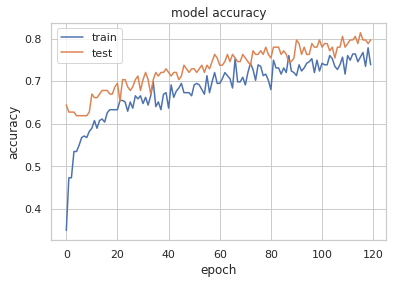

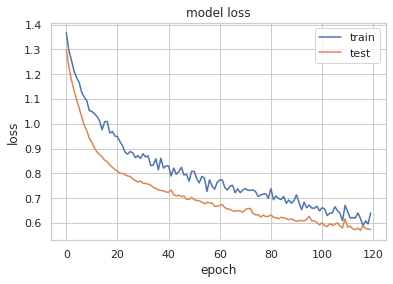

4/4 [==============================] - 0s 4ms/step - loss: 0.5740 - accuracy: 0.7966
[0.5740187764167786, 0.7966101765632629]


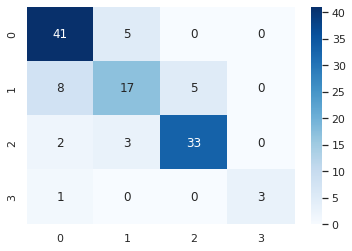

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 64)                768       
                                                                 
 dense_144 (Dense)           (None, 64)                4160      
                                                                 
 dropout_73 (Dropout)        (None, 64)                0         
                                                                 
 dense_145 (Dense)           (None, 64)                4160      
                                                                 
 dropout_74 (Dropout)        (None, 64)                0         
                                                                 
 dense_146 (Dense)           (None, 4)                 260       
                                                                 
Total params: 9,348
Trainable params: 9,348
Non-train

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:65: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)


None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


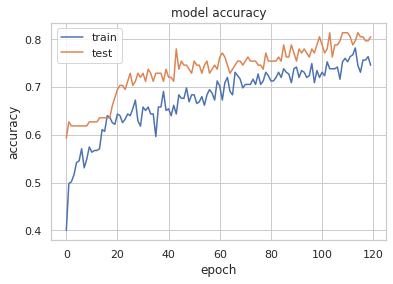

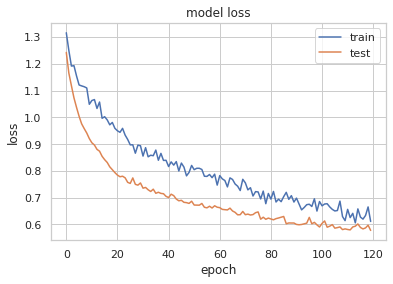

4/4 [==============================] - 0s 4ms/step - loss: 0.5776 - accuracy: 0.8051
[0.5776270031929016, 0.805084764957428]


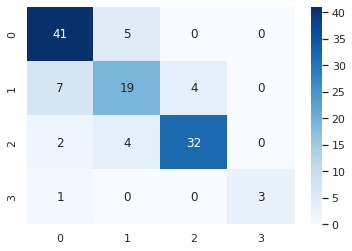

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 64)                768       
                                                                 
 dense_148 (Dense)           (None, 64)                4160      
                                                                 
 dropout_75 (Dropout)        (None, 64)                0         
                                                                 
 dense_149 (Dense)           (None, 64)                4160      
                                                                 
 dropout_76 (Dropout)        (None, 64)                0         
                                                                 
 dense_150 (Dense)           (None, 4)                 260       
                                                                 
Total params: 9,348
Trainable params: 9,348
Non-train

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:65: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)


None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


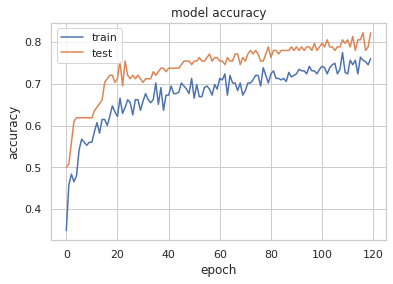

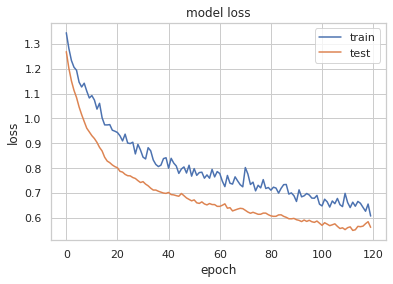

4/4 [==============================] - 0s 4ms/step - loss: 0.5621 - accuracy: 0.8220
[0.5621253848075867, 0.8220338821411133]


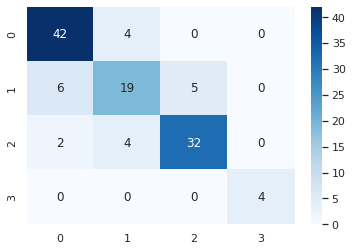

[0.79347826 0.81521739 0.79120879]
Accuracy:0.7999681477942348


In [16]:
clf = KerasClassifier(build_fn=create_model, verbose=0)
scores = cross_val_score(clf, X_train, y_train, cv=3,scoring='accuracy')
print(scores)
print("Accuracy:"+ str(scores.mean()))